# Packages/Functions

In [11]:
%reset -f

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# import functions required for processing of the FRS data
import SpectralData as SD
import frsprocessing as frs
import tdf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fig 5
## Import Data

In [12]:
### FRS data ###
df_FRS_new = pd.read_excel(r'data\metafile FRS ISA2 - 2.xlsx')
freq_FRS, hc_FRS = frs.batch_readCSVspectra([os.path.join('data',x) for x in df_FRS_new['path']])
freq = freq_FRS * 0.998 # correct an incorrect scaling of the frequency axis of the FRS data that is present in the raw data

### FTIR data ###
df_FTIR_new = pd.read_excel(r'data\metafile FTIR.xlsx')
freq_FTIR, abs_FTIR  = frs.batch_readJSON([os.path.join('data',x) for x in df_FTIR_new['path']])
abs_FTIR = frs.interp_dataset(freq, freq_FTIR, abs_FTIR) # interpolate the FTIR spectra to the same freuency grid as the FRS data
t_FTIR = 10**(-abs_FTIR/2) # convert absorbance to transmission data

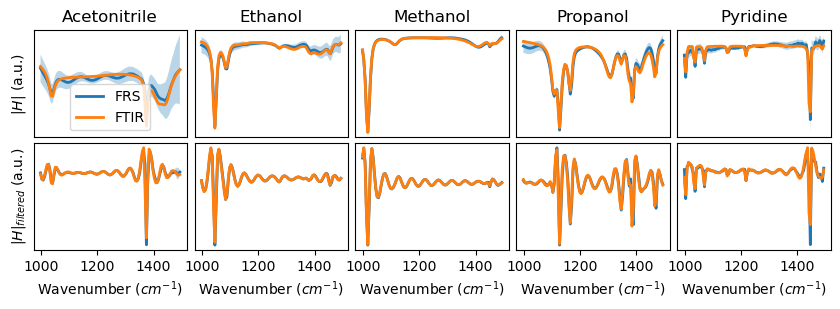

In [13]:
t1 = 700 # onset in fs of the applied time-domain filter
f1, f2   = (np.abs(freq  - 1000)).argmin(), (np.abs(freq  - 1500)).argmin() # set frequency range

### plotting ###
fig, ax = plt.subplots(2,5, figsize= (18*2/3.5,10/3.5))
ax = ax.ravel()
for i, substance  in enumerate(df_FRS_new['substance'].unique()): # loop through all substances
    # select substance
    index_FRS = df_FRS_new[(df_FRS_new['substance'] == substance) & (df_FRS_new['conc'] == 1)].index
    index_FTIR = df_FTIR_new[(df_FTIR_new['substance'] == substance) & (df_FTIR_new['conc'] == 1)].index
    
    # for better comparison of FTIR and FRS spectra, all spectra are baseline corrected and normalised.
    fm = np.vstack([hc_FRS[index_FRS], t_FTIR[index_FTIR]]) # combine FRS and FTIR data into one array
    fm = SD.basecorrnorm(freq, fm, 1000, 1500) # normalize spectra
    fm_tdf = tdf.tdf(freq, fm, t1, w_f=SD.tukeyF(freq,1000,1500,25)) # time-domain filtering
    fm_tdf = SD.basecorrnorm(freq, fm_tdf, 1000, 1500) # normalize spectra
    f, m = fm[:index_FRS.size], fm[index_FRS.size:].real # split combined dataset to FRS and FTIR data again
    f_tdf, m_tdf = fm_tdf[:index_FRS.size], fm_tdf[index_FRS.size:].real # split combined dataset to FRS and FTIR data again
    
    # calculate the mean and std of the non-filtered data and plot the results
    f_mean = np.mean(f,axis=0)
    f_std  = np.std(f,axis=0)
    m_mean = np.mean(m,axis=0)
    m_std  = np.std(m,axis=0)
    
    ax[i].plot(freq[f1:f2], f_mean[f1:f2].real, linewidth=2, label = 'FRS')
    ax[i].fill_between(freq[f1:f2], f_mean[f1:f2].real-f_std[f1:f2].real, f_mean[f1:f2].real+f_std[f1:f2].real, alpha=0.3)
    ax[i].plot(freq[f1:f2], m_mean[f1:f2].real, linewidth=2, label = 'FTIR')
    ax[i].fill_between(freq[f1:f2], m_mean[f1:f2].real-m_std[f1:f2].real, m_mean[f1:f2].real+m_std[f1:f2].real, alpha=0.3)
    
    # calculate the mean and std of the time-domain filtered data and plot the results
    f_tdf_mean = np.mean(f_tdf,axis=0)
    f_tdf_std  = np.std(f_tdf,axis=0)
    m_tdf_mean = np.mean(m_tdf,axis=0)
    m_tdf_std  = np.std(m_tdf,axis=0)
    
    ax[i+5].plot(freq[f1:f2], f_tdf_mean[f1:f2].real, linewidth=2, label = 'FRS')
    ax[i+5].fill_between(freq[f1:f2], f_tdf_mean[f1:f2].real-f_tdf_std[f1:f2].real, f_tdf_mean[f1:f2].real+f_tdf_std[f1:f2].real, alpha=0.3)
    ax[i+5].plot(freq[f1:f2], m_tdf_mean[f1:f2].real, linewidth=2, label = 'FTIR')
    ax[i+5].fill_between(freq[f1:f2], m_tdf_mean[f1:f2].real-m_tdf_std[f1:f2].real, m_tdf_mean[f1:f2].real+m_tdf_std[f1:f2].real, alpha=0.3)
    
    ax[i].set_xticks([]), ax[i].set_title(substance)
    ax[i+5].set_xlabel('Wavenumber ($cm^{-1}$)')
    ax[i].set_yticks([]), ax[i+5].set_yticks([])
    

fig.subplots_adjust(hspace=0.05, wspace=0.05)
ax[0].set_ylabel('$|H|$ (a.u.)'), ax[5].set_ylabel('$|H|_{filtered}$ (a.u.)')
ax[0].legend()

# Plots for Figure 6

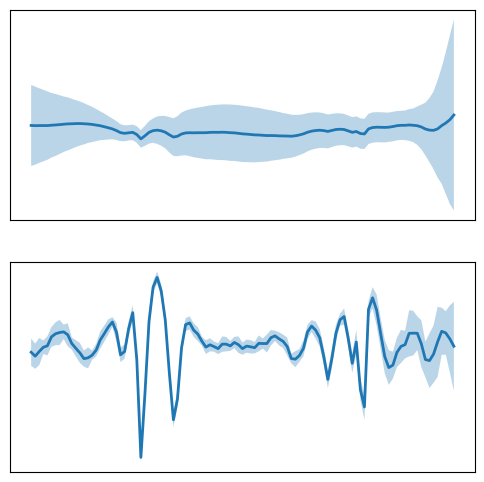

In [14]:
f1, f2   = (np.abs(freq  - 1000)).argmin(), (np.abs(freq  - 1500)).argmin() # select spectral range

fig, ax = plt.subplots(2, figsize=(6,6))
ax = ax.ravel()

# select substance to plot
index_FRS = df_FRS_new[(df_FRS_new['substance'] == 'Propanol') & (df_FRS_new['conc'] == 0.01)].index

# calculate the mean and std of the non-filtered data and plot the results
f = hc_FRS[index_FRS]
f = SD.linbasecorr(freq_FRS, f-1, 1000, 1500)+1
f_mean = np.mean(f,axis=0)
f_std  = np.std(f,axis=0)

ax[0].plot(freq[f1:f2], f_mean[f1:f2].real, linewidth=2, label = 'FRS')
ax[0].fill_between(freq[f1:f2], f_mean[f1:f2].real-f_std[f1:f2].real, f_mean[f1:f2].real+f_std[f1:f2].real, alpha=0.3)

# calculate the mean and std of the time-domain filtered data and plot the results
f      = tdf.tdf(freq_FRS, f, 500, w_f=SD.tukeyF(freq_FRS, 1000, 1425, 75))
f      = SD.linbasecorr(freq_FRS, f-1, 1000, 1500)+1
f_mean = np.mean(f,axis=0)
f_std  = np.std(f,axis=0)

ax[1].plot(freq[f1:f2], f_mean[f1:f2].real, linewidth=2, label = 'FRS')
ax[1].fill_between(freq[f1:f2], f_mean[f1:f2].real-f_std[f1:f2].real, f_mean[f1:f2].real+f_std[f1:f2].real, alpha=0.3)

for i in range(2):
    ax[i].set_xticks([]), ax[i].set_yticks([])

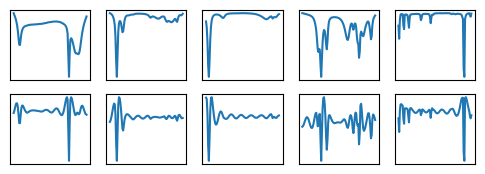

In [15]:
f1, f2   = (np.abs(freq  - 1000)).argmin(), (np.abs(freq  - 1500)).argmin() # select spectral range

fig, ax = plt.subplots(2,5, figsize= (6,2))
ax = ax.ravel()
for i, substance  in enumerate(df_FRS_new['substance'].unique()): # loop thtrough all substances
    # select substance
    index_FTIR = df_FTIR_new[(df_FTIR_new['substance'] == substance) & (df_FTIR_new['conc'] == 1)].index

    # calculate the mean of the non-filtered data and plot the results
    m =  t_FTIR[index_FTIR]
    m = SD.basecorrnorm(freq, m, 1000, 1500)
    m_mean = np.mean(m,axis=0)
    ax[i].plot(freq[f1:f2], m_mean[f1:f2].real, label = 'FTIR')

    # calculate the mean of the time-domain filtered data and plot the results
    m_tdf = tdf.tdf(freq_FRS, m, 500, w_f=tdf.tukeyF(freq_FRS, 1000, 1500, 75))
    m_tdf = SD.basecorrnorm(freq, m_tdf, 1000, 1500)
    m_tdf_mean = np.mean(m_tdf,axis=0)
    ax[i+5].plot(freq[f1:f2], m_tdf_mean[f1:f2].real, label = 'FTIR')
    
    ax[i].set_xticks([])
    ax[i+5].set_xticks([])
    ax[i].set_yticks([]), ax[i+5].set_yticks([])